## task 1：代码复现

### 生成符合ARMA(1,1)的时间序列

In [3]:
import numpy as np
import pandas as pd

# 设置随机种子
np.random.seed(42)

# 设置ARMA(1,1)的参数 
n = 200 # 序列长度
phi_1 = 0.8 # AR(1)系数
theta_1 = 0.8 # MA(1)系数
epsilon = np.random.normal(0, 1, n) # 生成白噪声

# 初始化序列
X = np.zeros(n)

# 生成ARMA(1,1)序列
for t in range(1, n):
    X[t] = phi_1 * X[t-1] + theta_1 * epsilon[t-1] + epsilon[t]
    
# 生成日期序列
start_date = '2024-09-13'
dates = pd.date_range(start=start_date, periods=n)

# 创建DataFrame
data = pd.DataFrame(data={'Value': X}, index=dates)
# 将日期设置为索引
data.index.name = 'Date'

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2024-09-13 to 2025-03-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   200 non-null    float64
dtypes: float64(1)
memory usage: 3.1 KB


In [5]:
data.head()

,Value
Date,
2024-09-13,0.000000
2024-09-14,0.259107
2024-09-15,0.744363
2024-09-16,2.636671
2024-09-17,3.093607


### 预处理与时序可视化

In [6]:
# 缺失值统计
missing_values = data.isna().sum()
print(missing_values)

Value    0
dtype: int64


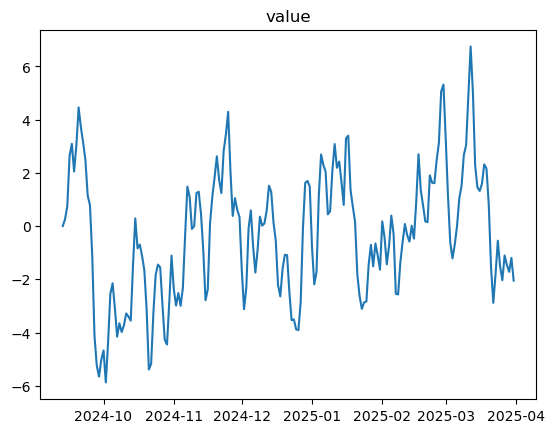

In [7]:
# 数据可视化
import matplotlib.pyplot as plt

plt.plot(data['Value'])
plt.title('value')
plt.show()

### 平稳性

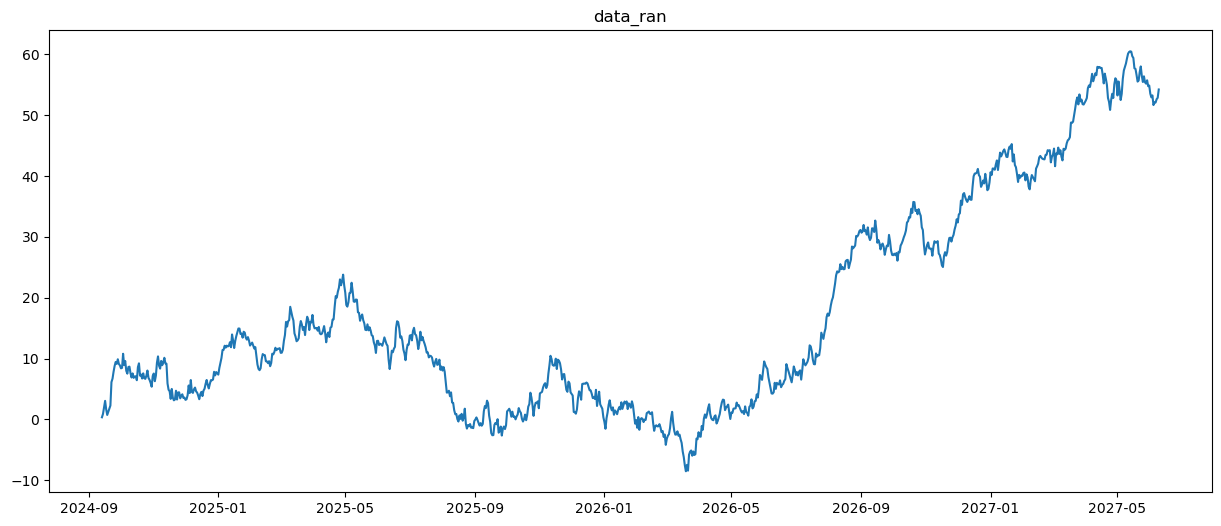

In [8]:
# 构建时间序列
data_ran = pd.DataFrame(
    np.random.randn(1000, 1), # 1000行1列
    index = pd.date_range('2024-09-13', periods=1000), # 行为索引
    columns = ['data'] # 列名
)
data_ran['data'] = data_ran['data'].cumsum()

plt.figure(figsize=(15, 6))
plt.plot(data_ran['data'])
plt.title('data_ran')
plt.show()

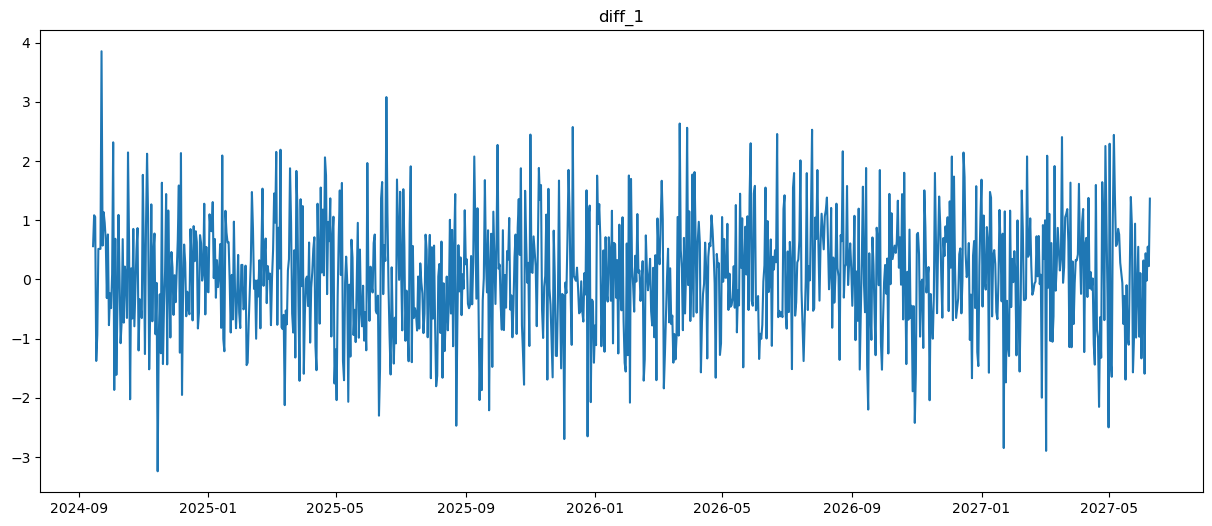

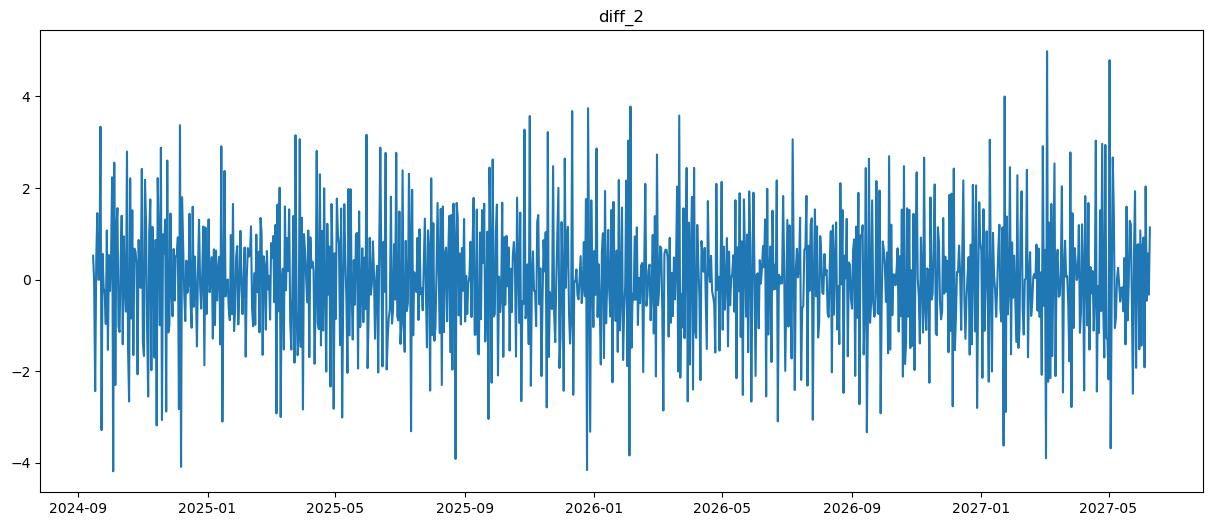

In [9]:
# 平稳性——差分处理

# 一阶差分处理
data_ran['diff_1'] = data_ran['data'].diff(1)
plt.figure(figsize=(15, 6))
plt.plot(data_ran['diff_1'])
plt.title('diff_1')
plt.show()

# 二阶差分处理
data_ran['diff_2'] = data_ran['diff_1'].diff(1)
plt.figure(figsize=(15, 6))
plt.plot(data_ran['diff_2'])
plt.title('diff_2')
plt.show()

可以看到，时间序列在进行一阶差分后就已经接近于平稳序列了

### 模型定阶

/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


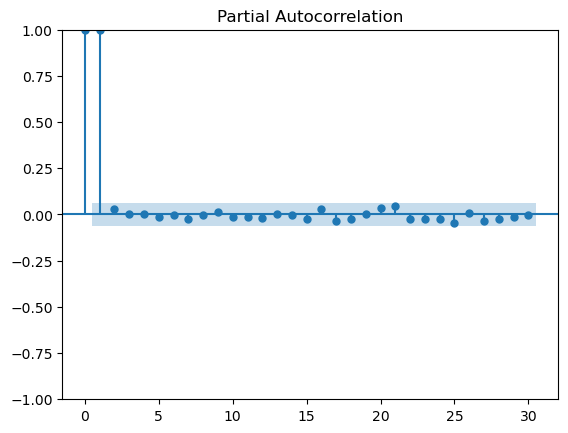

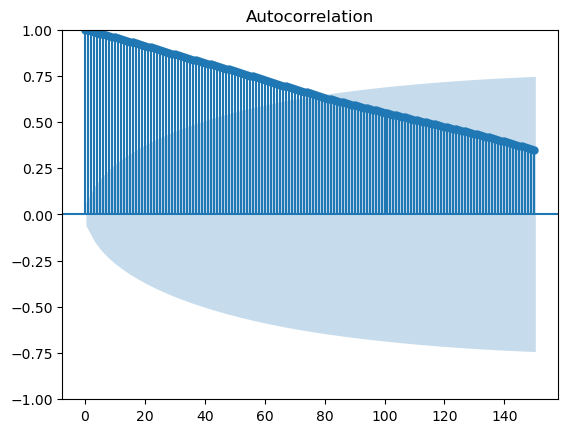

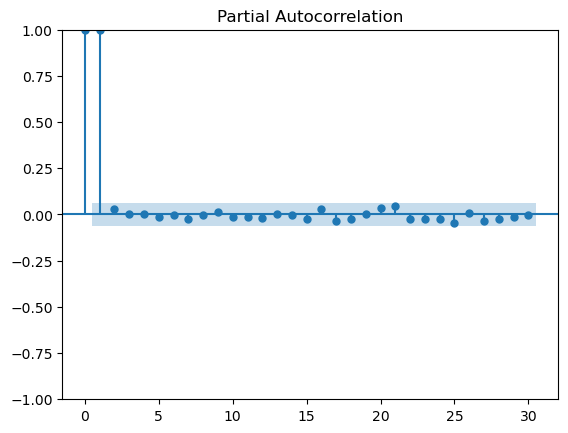

In [10]:
from scipy import stats
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(data_ran['data'], lags=150) # 自相关系数
sm.graphics.tsa.plot_pacf(data_ran['data'], lags=30) # 偏自相关系数

### 平稳时间序列建模

平稳性检验

In [11]:
from statsmodels.tsa.stattools import adfuller as ADF
diff = 0
# 采用单位根检验ADF检验时序是否平稳
def ADF_test(series):
    adf = ADF(series)
    if adf[1] > 0.05:
        print('序列是不平稳的,p为:', adf[1])
    else:
        print('序列是平稳的,p为:', adf[1])
        
ADF_test(data['Value'])

序列是平稳的,p为: 0.021327484537574687


白噪声检验

In [12]:
# 若序列是白噪声序列，说明序列中有用的信息已经提取完毕，只剩随机扰动
# 采用LB统计量进行白噪声检验
def white_noise_test(series):
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb = acorr_ljungbox(series, lags=1)
    p = lb.values[0,1]
    if p<0.05:
        print('序列是非白噪声序列,p为:', p)
    else:
        print('序列是白噪声序列,p为:', p)
        
white_noise_test(data['Value'])

序列是非白噪声序列,p为: 4.730007280799861e-36


In [13]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 定义绘图函数，画出原信号、ACF、PACF图
def plotds(xt, nlag=30, fig_size=(12, 10)):
    if not isinstance(xt, pd.Series):
        xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # 指定轴
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax_acf = plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    # 绘制图像
    xt.plot(ax=ax_xt)
    ax_xt.set_title('Time Series Analysis Plots')
    plot_acf(xt, lags=nlag, ax=ax_acf)
    plot_pacf(xt, lags=nlag, ax=ax_pacf)
    plt.tight_layout()
    plt.show()
    return None

/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


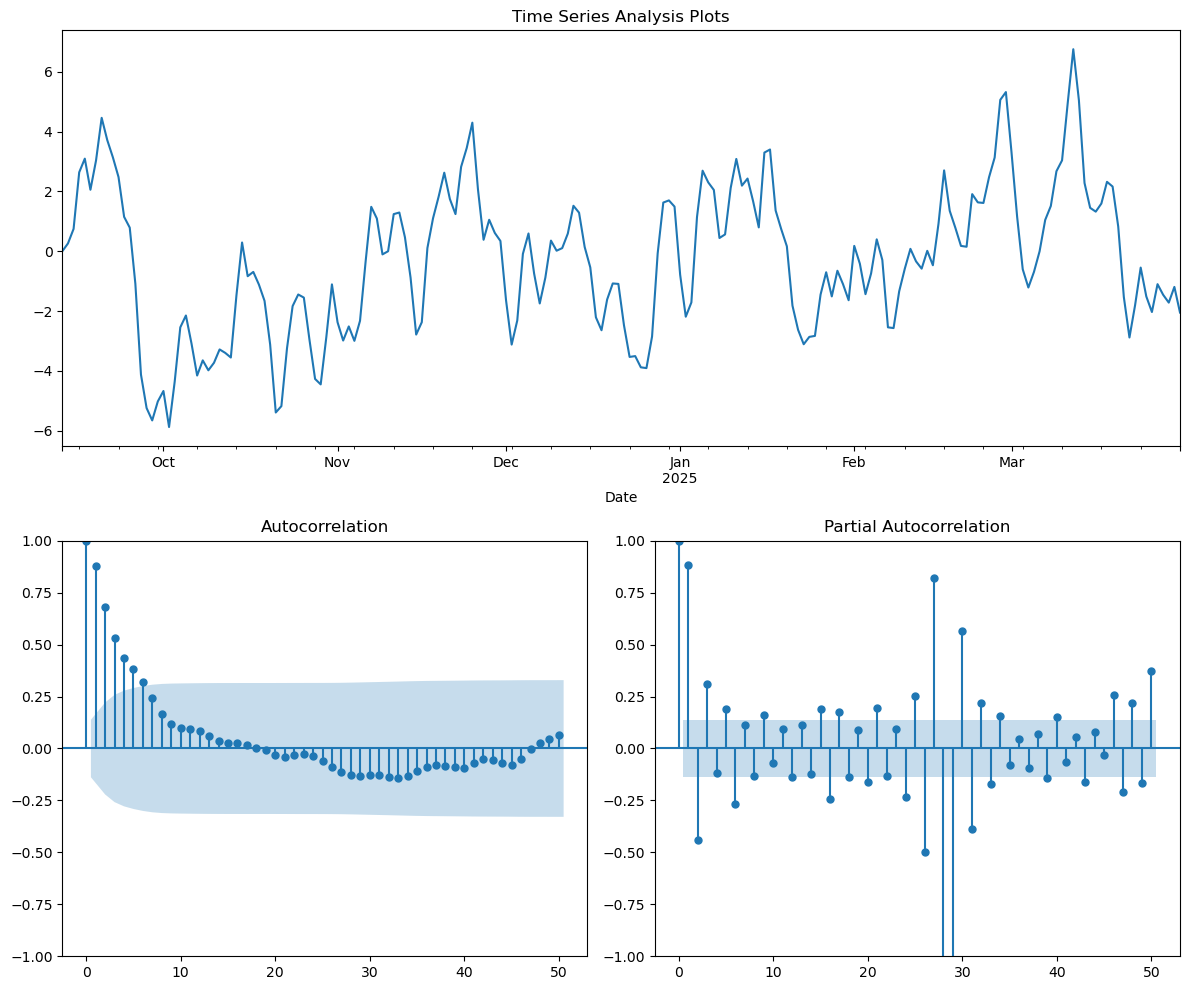

In [14]:
# 画出三图
plotds(data['Value'], nlag=50)

根据ACF、PACF图可以发现均为拖尾的，因此我们采用ARMA模型，并想要进一步确定模型阶数

In [15]:
import statsmodels.tsa.api as smtsa

aicVal = []
for ari in range(0,3):
    for maj in range(0,3):
        try:
            arma_obj = smtsa.ARIMA(data['Value'].tolist(), order=(ari, 0, maj)).fit(method='innovations_mle')
            print(arma_obj.summary())
            aicVal.append([ari, maj, arma_obj.aic])
        except Exception as e:
            print(e)

print(aicVal)
min_aic = min(aicVal, key=lambda x: x[2])
best_ari = min_aic[0]
best_maj = min_aic[1]

print("Best AR order (ari): ", best_ari)
print("Best MA order (maj): ", best_maj)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                          ARIMA   Log Likelihood                -459.649
Date:                Sun, 15 Sep 2024   AIC                            923.298
Time:                        09:13:57   BIC                            929.894
Sample:                             0   HQIC                           925.967
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3155      0.171     -1.849      0.065      -0.650       0.019
sigma2         5.8044      0.635      9.137      0.000       4.559       7.049
Ljung-Box (L1) (Q):                 157.16   Jarque-

利用AIC准则，选择AIC最小的阶数作为ARMA(p,q)的模型，即p=1,q=1

In [16]:
model = smtsa.ARIMA(data['Value'], order=(best_ari, 0, best_maj))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  200
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -269.369
Date:                Sun, 15 Sep 2024   AIC                            546.738
Time:                        09:14:10   BIC                            559.931
Sample:                    09-13-2024   HQIC                           552.077
                         - 03-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3596      0.488     -0.737      0.461      -1.316       0.597
ar.L1          0.7446      0.050     14.881      0.000       0.646       0.843
ma.L1          0.8556      0.039     22.169      0.0

### 利用ARMA模型进行预测与拟合

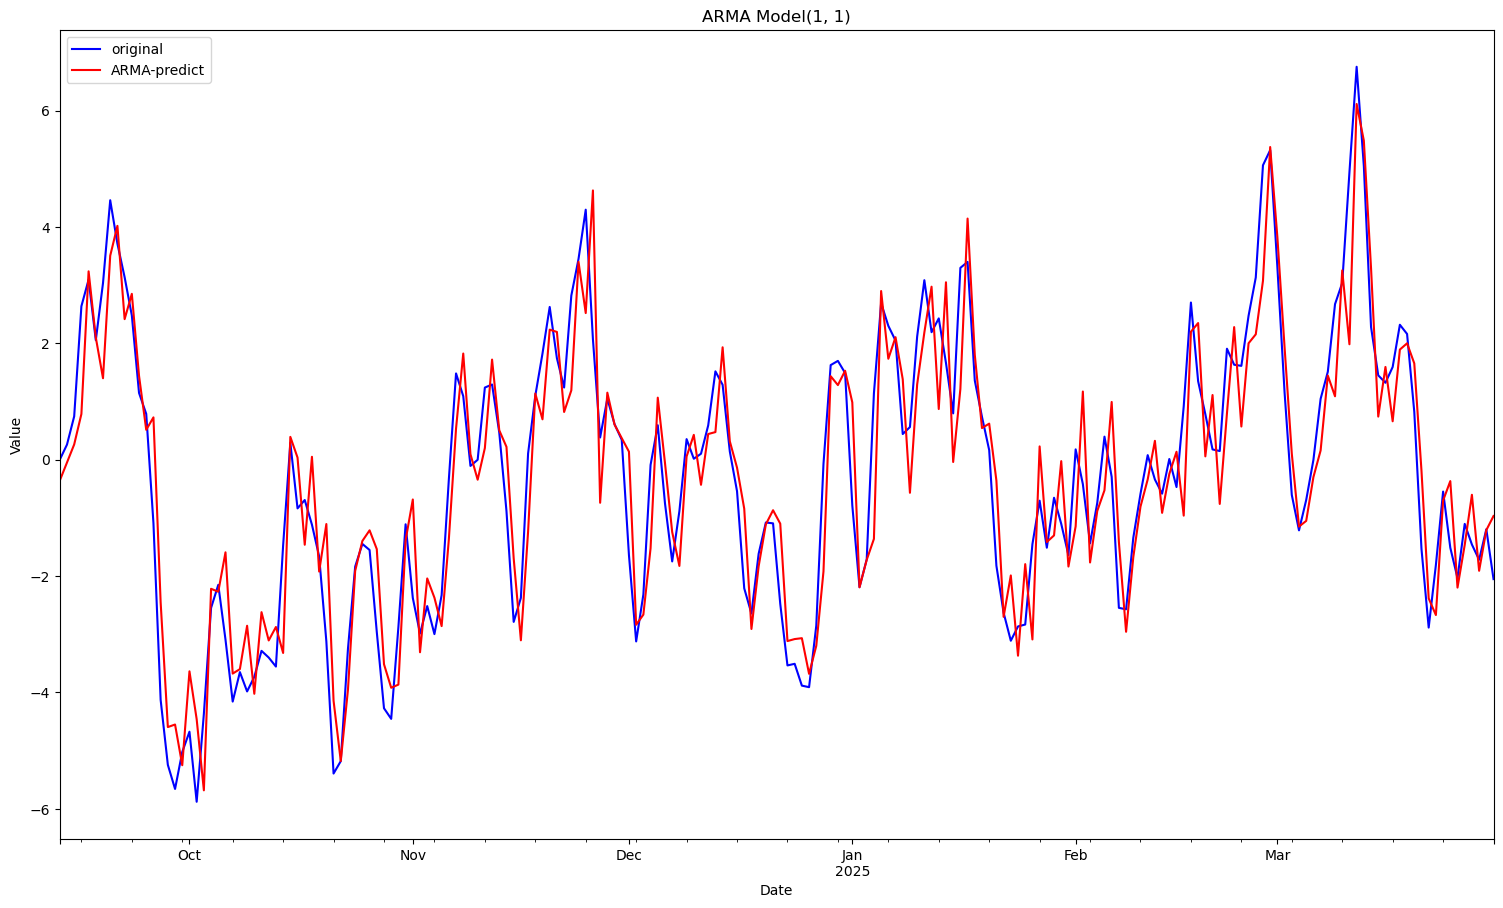

In [17]:
# 将拟合结果存储到data变量，列名命名为ARMA
data['ARMA'] = model_fit.predict(typ='levels',dynamic=False)
fig, ax = plt.subplots(1, sharex=True)
fig.set_size_inches(18.5, 10.5)

# 画出真实数据图像
data['Value'].plot(ax=ax, label='original', color='blue')
# 画出拟合数据图像
data['ARMA'].plot(ax=ax, label='ARMA-predict', color='red')
ax.set_title('ARMA Model(%s, %s)' % (best_ari, best_maj))

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

模型后期预测

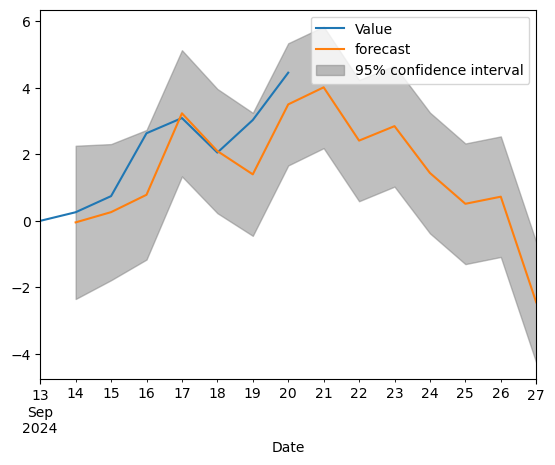

In [18]:
from statsmodels.graphics.tsaplots import plot_predict

temp = data.Value['20240913':'20240920']
fig, ax = plt.subplots()
ax = temp.loc['20240913':'20240927'].plot(ax=ax)
plot_predict(model_fit, '20240914', '20240927', ax=ax)
plt.show()

### 非平稳时序建模和预测

In [19]:
# 1.准备数据
stockFile = 'exp1_data/data-stock_train.csv'
stock_df = pd.read_csv(stockFile, index_col=0, parse_dates=[0]) # 指定索引为Date，并处理为日期格式 
stock_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,129.226151,127.205109,129.226151,127.678436,5896979.0,105.634399
2010-01-05,128.850494,126.972198,128.467316,127.302780,4194404.0,105.323608
2010-01-06,127.347855,124.951164,126.964691,125.289253,5309229.0,103.657715
2010-01-07,125.612320,121.622841,125.289253,123.005257,6498680.0,101.768059
2010-01-08,123.215630,120.285500,123.215630,121.712997,4885048.0,100.698906


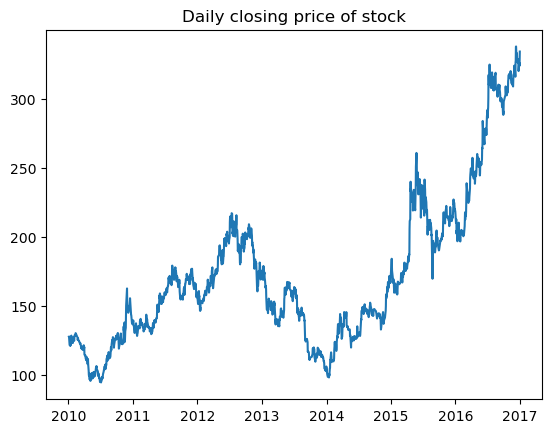

In [20]:
# 收盘数据可视化
plt.plot(stock_df['Close']) # 收盘价
plt.title('Daily closing price of stock')
plt.show()

In [21]:
print(stock_df.Close['20100104':'20100112'])
print('='*50)
# 2.重采样，线性填充
stock_df = stock_df.resample('D').interpolate(method='linear') # 用插值法拟合出缺失的数据，然后进行填充
print(stock_df.Close['20100104':'20100112'])

Date
2010-01-04    127.678436
2010-01-05    127.302780
2010-01-06    125.289253
2010-01-07    123.005257
2010-01-08    121.712997
2010-01-11    121.179565
2010-01-12    124.455299
Name: Close, dtype: float64
Date
2010-01-04    127.678436
2010-01-05    127.302780
2010-01-06    125.289253
2010-01-07    123.005257
2010-01-08    121.712997
2010-01-09    121.535187
2010-01-10    121.357376
2010-01-11    121.179565
2010-01-12    124.455299
Freq: D, Name: Close, dtype: float64


使用单位根检验的方法(ADF_test)和白噪声检验(white_noise_test)检验时序数据的平稳性

建立模型

                High       Low      Open     Close     Volume  Adj Close
Date                                                                    
2010-01-05 -0.375656 -0.232910 -0.758835 -0.375656 -1702575.0  -0.310791
2010-01-06 -1.502640 -2.021034 -1.502625 -2.013527  1114825.0  -1.665894
2010-01-07 -1.735535 -3.328323 -1.675438 -2.283997  1189451.0  -1.889656
2010-01-08 -2.396690 -1.337341 -2.073624 -1.292259 -1613632.0  -1.069153
2010-01-09  0.225393  0.100174 -0.100176 -0.177811  -543095.0  -0.147110
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object


/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


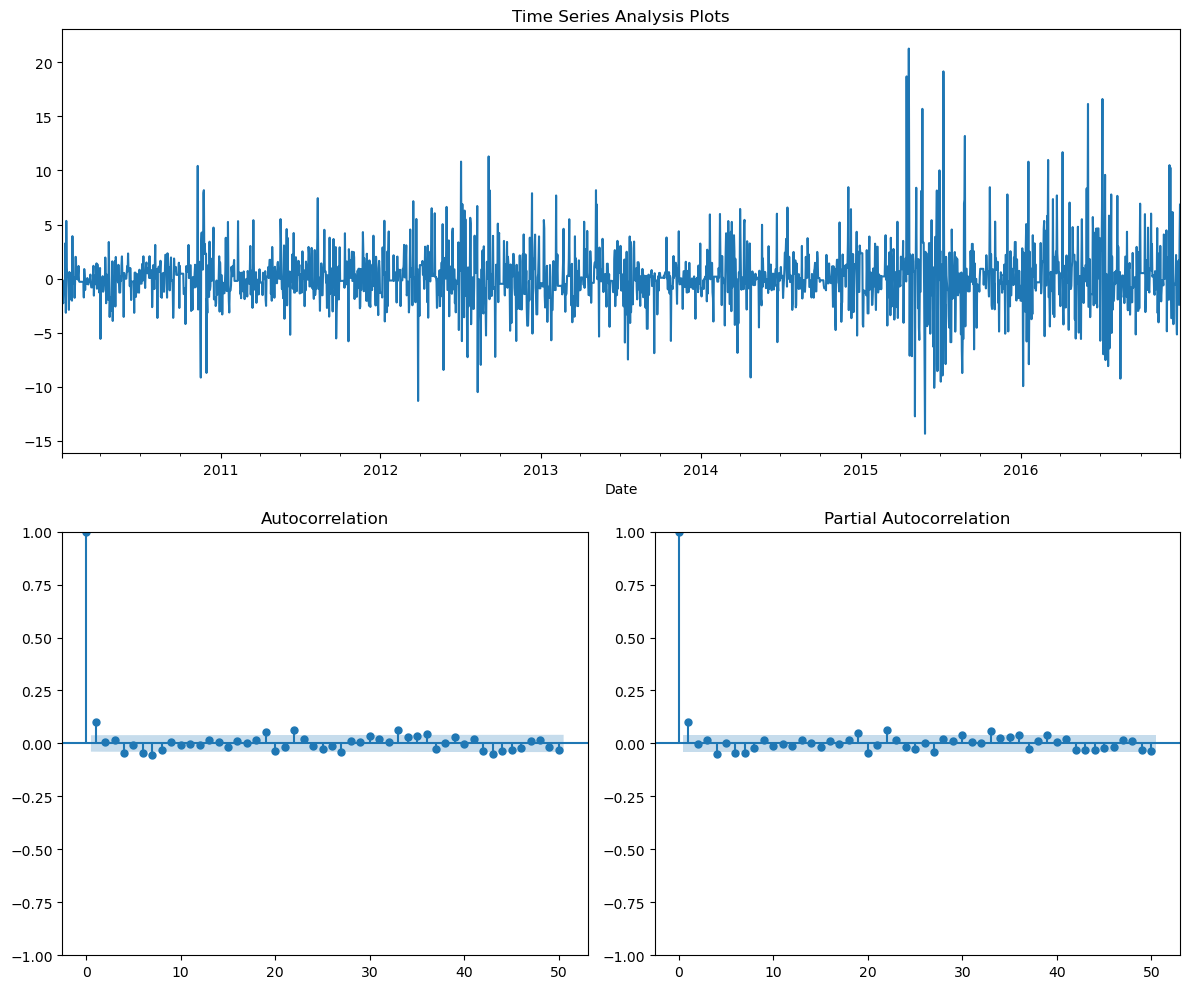

In [22]:
# 3.进行一阶差分
stock_diff = stock_df.diff(1)
diff = stock_diff.dropna()

print(diff.head())
print(diff.dtypes)

plotds(diff['Close'], nlag=50)

In [23]:
# 4.根据ACF和PACF图来定阶，选择合适的ARIMA模型
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(stock_df['Close'], order=(2, 1, 2)) # p=2, d=1, q=2
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2553
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6009.530
Date:                Sun, 15 Sep 2024   AIC                          12029.059
Time:                        09:14:20   BIC                          12058.283
Sample:                    01-04-2010   HQIC                         12039.658
                         - 12-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5037      0.339     -1.488      0.137      -1.167       0.160
ar.L2          0.2338      0.176      1.332      0.183      -0.110       0.578
ma.L1          0.6088      0.341      1.784      0.0

有些时候直接观察ACF和PACF图来选择参数会存在偏差，因此可以穷举AIC值来选p, q,即AIC越小，模型越好

In [24]:
# 模型的识别和定阶
# 使用差分后的数据进行模型定阶
data = stock_diff['Close']
aicVal = []
for ari in range(1,10):
    for maj in range(1,6):
        try:
            arma_obj = ARIMA(data, order=(ari, 0, maj)).fit()
            aicVal.append([ari, maj, arma_obj])
        except Exception as e:
            print(e)
            
# 建立[p,q,aic]三元组
aic_ = [item[2].aic for item in aicVal]
arma = [[ar,ma] for ar,ma,_ in aicVal]
for row,col in zip(arma,aic_):
    row.append(col)
    
print(arma)

/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  wa

[[1, 1, 12029.707275839008], [1, 2, 12031.809638039449], [1, 3, 12027.709584616421], [1, 4, 12024.75300097821], [1, 5, 12026.4732287589], [2, 1, 12031.701214225868], [2, 2, 12029.00234529636], [2, 3, 12028.907929414925], [2, 4, 12025.211528091919], [2, 5, 12026.98128488944], [3, 1, 12028.185724345432], [3, 2, 12029.48839898586], [3, 3, 12022.406812146171], [3, 4, 12024.351512594221], [3, 5, 12019.389623021614], [4, 1, 12028.088960205601], [4, 2, 12024.290605319615], [4, 3, 12024.345445157378], [4, 4, 12026.204613503494], [4, 5, 12022.837383973947], [5, 1, 12029.559758452444], [5, 2, 12025.961643670875], [5, 3, 12026.843409082216], [5, 4, 12022.818915595744], [5, 5, 12020.511938606889], [6, 1, 12022.444242809255], [6, 2, 12023.51431137383], [6, 3, 12020.91733084535], [6, 4, 12022.642117487794], [6, 5, 12022.869247287608], [7, 1, 12023.234641394261], [7, 2, 12025.025238153621], [7, 3, 12027.455266014073], [7, 4, 12024.066609552969], [7, 5, 12025.833297591866], [8, 1, 12023.822882721615],

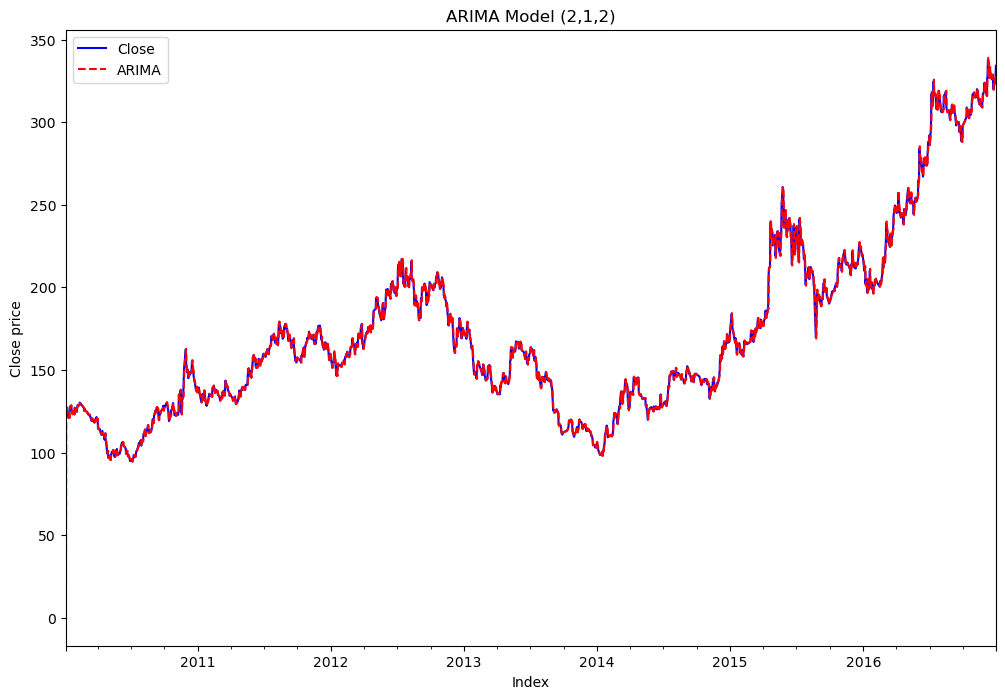

In [25]:
# 回归原数据对模型进行拟合
stock_df['ARIMA'] = model_fit.predict(typ='levels')
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(12, 8)
# 画出真实数据以及拟合数据图像
stock_df['Close'].plot(ax=axarr, color='b', linestyle='-', label='Close')
stock_df['ARIMA'].plot(ax=axarr, color='r', linestyle='--', label='ARIMA')
axarr.set_title('ARIMA Model (2,1,2)')
plt.xlabel('Index')
plt.ylabel('Close price')
plt.legend()
plt.show()

模型评估与预测

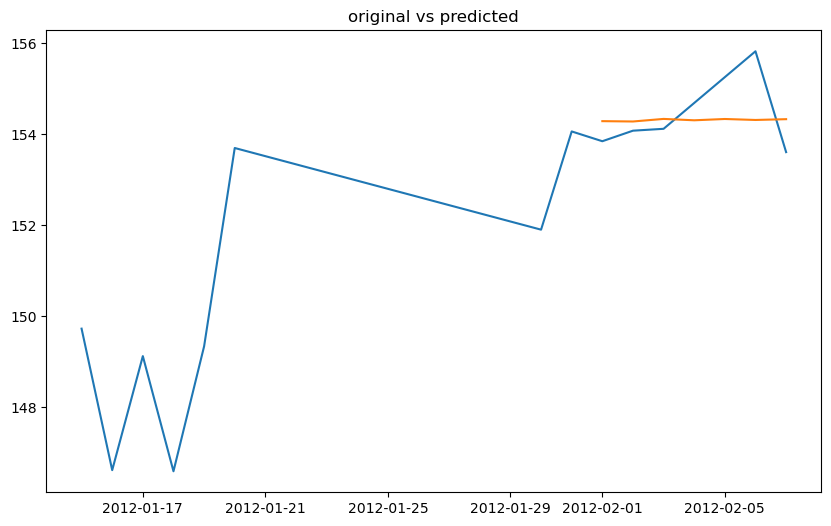

In [32]:
# 5.预测
output = model_fit.predict('20120201', '20120207', dynamic=True, typ='levels')
# 6.可视化预测结果
# 展示部分数据与预测数据的对比结果
stock_forecast = pd.concat([stock_df.Close['20120115':'20120207'], output], axis=1, keys=['original', 'predicted'])
plt.figure(figsize=(10, 6))
plt.plot(stock_forecast)
plt.title('original vs predicted')
plt.show()

对短期预测结果进行评估

In [36]:
import math
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

In [37]:
short_label = stock_df.Close['20120201':'20120202']
short_prediction = output[:2]
short_mse = mse(short_label, short_prediction)
short_rmse = math.sqrt(short_mse)
short_mae = mae(short_label, short_prediction)
print('short_mse:%.4f, short_rmse:%.4f, short_mae:%.4f' % (short_mse, short_rmse, short_mae))

short_mse:0.1175, short_rmse:0.3429, short_mae:0.3214


对长期预测结果进行评估

In [38]:
all_label = stock_df.Close['20120201':'20120207']
all_prediction = output
all_mse = mse(all_label, all_prediction)
all_rmse = math.sqrt(all_mse)
all_mae = mae(all_label, all_prediction)
print('all_mse:%.4f, all_rmse:%.4f, all_mae:%.4f' % (all_mse, all_rmse, all_mae))

all_mse:0.5817, all_rmse:0.7627, all_mae:0.6275


根据结果可以得出：短期预测结果更好

模型后期预测

In [39]:
dta = stock_df.Close['20161215':'20161230']
dta

Date
2016-12-15    328.049988
2016-12-16    327.579987
2016-12-17    327.039988
2016-12-18    326.499990
2016-12-19    325.959991
2016-12-20    326.480011
2016-12-21    328.660004
2016-12-22    325.200012
2016-12-23    320.029999
2016-12-24    321.513336
2016-12-25    322.996674
2016-12-26    324.480011
2016-12-27    326.160004
2016-12-28    323.720001
2016-12-29    327.309998
2016-12-30    334.149994
Freq: D, Name: Close, dtype: float64

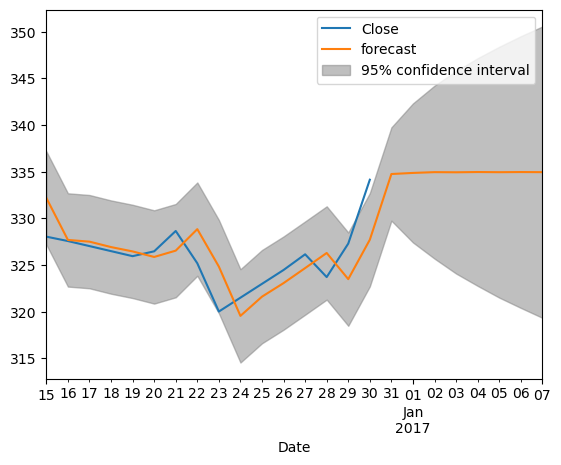

In [40]:
fig, ax = plt.subplots()
dta.loc['20161215':'20170107'].plot(ax=ax)
fig = plot_predict(model_fit, '20161215', '20170107', ax=ax)
plt.show()